# Loading data & Time conversion

In [ ]:
# load activity data
import pandas as pd

def read_act_df(base_dir, time_cols=['Started', 'Finished', 'Updated']):
    act_df = pd.read_csv(base_dir)
    act_df = act_df.dropna(subset=time_cols)

    for col in time_cols:
        act_df[col] = pd.to_datetime(act_df[col], format='%Y/%m/%d %H:%M')
        if act_df[col].isna().any():
            raise ValueError(f"Column '{col}' contains NaN or unparseable datetime values.")
        act_df[col] = act_df[col].dt.tz_localize('UTC+09:00')

    return act_df

act_path = '../data/TrainingDataPD25/TrainActivities.csv'
act_df = read_act_df(act_path)
display(act_df.head(10))
print(act_df['Activity Type'].value_counts().index)

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
5,1130293,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
6,1130294,2808,3 Stand up from chair - both hands with SHAKING,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
7,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1
8,1136872,2806,1 (FACING camera) Sit and stand,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,U22
9,1136878,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 19:56:00+09:00,2024-09-03 19:57:00+09:00,2024-09-03 19:57:00+09:00,U22


Index(['1 (FACING camera) Sit and stand',
       '2 (FACING camera) both hands SHAKING (sitting position)',
       '3 Stand up from chair - both hands with SHAKING',
       '5 (Sideway) both hands SHAKING (sitting)',
       '6 (Sideway) STAND up with - both hands SHAKING',
       '10 Slow walk (SHAKING hands/body, tiny step, head forward)',
       '4 (Sideway) Sit & stand', '8 Walk (LEFT --> Right --> Left)',
       '9 Walk & STOP/frozen, full body shaking, rotate then return back',
       '7 Cool down - sitting/relax'],
      dtype='object', name='Activity Type')


In [21]:
# Load acceleration data
# load all csv files into a DataFrame
import os
import glob

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """ Read all csv files in users folder 
    Return:
        users_df: a DataFrame contains all csv files
    Args:
        base_dir: base folder to csv files
        headers: headers for csv files
    """
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    users_df.sort_values(by=['datetime'], inplace=True)
    return users_df

users_df = read_users_df(base_dir, headers)

# Prepare the data for feature extraction

In [73]:
def preprocess_acceleration_df(users_df):
    """
    Remove duplicates replace with mean values
    Parameters
    ----------
    users_df : DataFrame
    """
    
    processed_df = users_df.groupby('datetime', as_index=False)[['x', 'y', 'z']].mean().reset_index(drop=True)
    return processed_df

def add_duration(df):
    """Adding duration between two given cols
    
    Return:
        DataFrame

    Args:
        df (DataFrame)
    """
    df_cp = df.copy()
    df_cp['Started'] = df_cp['Started'].dt.floor('s')
    df_cp['Finished'] = df_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)
    return df_cp

def preprocess_activity_label_df(act_df):
    """
    1. Remove duplicates based on 'Started', 'Finished', 'Activity Type', 'Subject'
    and keep the most lastest 'Update' time
    2. Add duration between 'Started' and 'Finished'
    3. Sort by 'Started' in ascending order
    Parameters
    ----------
    act_df : DataFrame
    """
    #1
    columns = ['Started', 'Finished', 'Activity Type', 'Subject']
    drop_dup_df = act_df.sort_values(by=['Updated'], ascending=False).drop_duplicates(subset=columns, keep='first').reset_index(drop=True)
    #2
    add_dur_df = drop_dup_df.copy()
    add_dur_df['Finished'] = add_dur_df['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)
    add_dur_df['Started'] = add_dur_df['Started'].dt.floor('s')
    #3
    sorted_df = add_dur_df.sort_values(by='Started', ascending=True).reset_index(drop=True)
    
    processed_df = sorted_df.copy() 
    return processed_df

### Dummy code to test

In [65]:
### check duplicates ###
# duplicates = users_df[users_df['datetime'].duplicated(keep=False)]
# duplicates.head(10)
# users_df actually has duplicates?????
# let calculate avg and drop duplicates
# averaged_df = users_df.groupby('datetime', as_index=False)[['x', 'y', 'z']].mean()
# print(act_df['Updated'].max())
# dups = act_df[act_df['Updated'] == act_df['Updated'].max()]
# duplicates = act_df[act_df.duplicated(
#     subset=['Started', 'Finished', 'Activity Type', 'Subject'], 
#     keep=False)].sort_values(
#         by=['Updated'], 
#         ascending=False)
# display(duplicates.head(10))
# display(dups.head(10))
# display(act_df.sort_values(
#     by=['Updated'],
#     ascending=False).head(10))
# There is multiple activities have the same Started, Finished, Activity Type, Subject but different Updated
# So we drop duplicates but keep the lastest Updated
# sorted_act_df = act_df.sort_values(by='Updated', ascending=False)
# drop_dups_act_df = sorted_act_df.drop_duplicates(
#     subset=['Started', 'Finished', 'Activity Type', 'Subject'], 
#     keep='first').reset_index(drop=True)
# drop_dups_act_df.head(10)
# drop_dups_act_df.shape
### check na ###
# users_df.isna().sum()
# act_df.isna().sum()
# there is no na at all
# def add_duration(df):
#     """Adding interval between two given cols
    
#     Return:
#         DataFrame: a dataframe with added interval between two columns

#     Args:
#         df (DataFrame): original dataframe
#     """
#     df_cp = df.copy()

#     df_cp['Started'] = df_cp['Started'].dt.floor('s')
#     df_cp['Finished'] = df_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

#     return df_cp

# dur_df = add_duration(act_df)
# display(dur_df[['Started', 'Finished']].head(10))
# display(act_df[['Started', 'Finished']].head(10))

# Segmentation

In [71]:
# segment acceleration data into one dataframe per row in label dataframe
# this leads to different activity could have same dataframe if they have same time range
def seg_accelertaion_df_per_activity(users_df, act_df, seg_test_set=False):
    """
    Segmenting the dataset into one dataframe per activity
    Description:
        Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.

    Return:
        seg_list: list of df, one df contains acceleration data of corresponding activity label
        seg_label_list: list of label. one label correspond to one df in seg_list
    
    Args:
        users_df: one big DataFrame of acceleration data
        act_df: activity labels DataFrame
    """

    seg_list = []
    seg_subject_list = []
    seg_label_list = []
    
    for i in range(0, len(act_df)):
        started_at = act_df.iloc[i]['Started']
        finished_at = act_df.iloc[i]['Finished']

        seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
        seg_subject = act_df.iloc[i]['Subject']
        if not seg_test_set:
            # seg_label = act_df.iloc[i]['Activity Type']
            seg_label = act_df.iloc[i]['Activity Type ID']

        # check if seq is not empty
        if len(seg) != 0:
            seg_list.append(seg)
            seg_subject_list.append(seg_subject)
            if not seg_test_set:
                seg_label_list.append(seg_label)
    
    if not seg_test_set:
        return seg_list, seg_subject_list, seg_label_list
    
    return seg_list, seg_subject_list

In [74]:
processed_users_df = preprocess_acceleration_df(users_df)
processed_act_df = preprocess_activity_label_df(act_df)
seg_list, seg_subject_list, seg_label_list = seg_accelertaion_df_per_activity(processed_users_df, processed_act_df, seg_test_set=False)

In [75]:
print(f'seg_list {len(seg_list)}')
print(f'seg_subject_list {len(seg_subject_list)}')
print(f'seg_label_list {len(seg_label_list)}')

seg_list 199
seg_subject_list 199
seg_label_list 199


# Feature extraction


In [ ]:
%pip install scipy numpy statsmodels

In [66]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis
from scipy.signal import periodogram

def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def safe_corr(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return np.corrcoef(a, b)[0, 1]

def band_energy(signal, fs=50, low=4, high=6):
    """Compute energy in a frequency band (e.g., 4–6 Hz for tremor)."""
    f, Pxx = periodogram(signal, fs=fs)
    return np.sum(Pxx[(f >= low) & (f <= high)])

def get_feats(df, columns=['x', 'y', 'z'], fs=50):
    """Method to extract features from acceleration dataframe.
    Returns
    -------
    feats: list of numpy values
        List of features extracted from the acceleration data.
    """
    feats = []
    tremor_band_energies = []

    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, zcr_
        ])

        # Tremor-specific feature (4–6 Hz band energy)
        tremor_energy = band_energy(data, fs=fs, low=4, high=6)
        tremor_band_energies.append(tremor_energy)

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Axis correlations
    feats.extend([
        safe_corr(df['x'], df['y']),
        safe_corr(df['y'], df['z']),
        safe_corr(df['z'], df['x']),
    ])

    # Append tremor band energy per axis and total
    feats.extend(tremor_band_energies)  # x, y, z band energy
    feats.append(sum(tremor_band_energies))  # total tremor energy

    return feats

## Window overlapping

In [82]:
def window_segment(df, wsize, stride):
    """Segment using sliding window method

    Returns:
        List: list of features per activity
    Args:
        df: accelerometer data
        wsize: window size [seconds]
        stride: how much the window slide
    """
    features_list = []
    start_time = df['datetime'].min()
    end_time = df['datetime'].max()
    current_start = start_time

    while current_start + pd.Timedelta(seconds=wsize) <= end_time:
        current_end = current_start + pd.Timedelta(seconds=wsize)
        window = df[(df['datetime'] >= current_start) & (df['datetime'] < current_end)]
        if not window.empty:
            feats = get_feats(window)
            features_list.append(feats)
        current_start += pd.Timedelta(seconds=stride)

    return features_list

def segment_all(seg_list, seg_label_list, seg_subject_list, wsize=1, stride=0.5):
    all_features = []
    all_labels = []
    all_subjects = []

    for df, label, subject in zip(seg_list, seg_label_list, seg_subject_list):
        feats_list = window_segment(df, wsize, stride)
        all_features.extend(feats_list)
        all_labels.extend([label] * len(feats_list))
        all_subjects.extend([subject] * len(feats_list))

    # Define feature names for columns (must match get_feats output)
    axes = ['x', 'y', 'z']
    base_features = ['std', 'mean', 'max', 'min', 'median', 'iqr', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zcr']
    tremor_band = ['tremor_energy']

    columns = []
    for axis in axes:
        for feat in base_features + tremor_band:
            columns.append(f'{feat}_{axis}')

    columns += ['sma', 'corr_xy', 'corr_yz', 'corr_zx', 'total_tremor_energy']

    features_df = pd.DataFrame(all_features, columns=columns)
    features_df['label'] = all_labels
    features_df['subject'] = all_subjects

    return features_df

In [125]:
WINDOW_SIZE = 0.5  # seconds
OVERLAP_RATE = 0.3 * WINDOW_SIZE  # seconds
all_features_and_labels_df = segment_all(seg_list, seg_label_list, seg_subject_list, wsize=WINDOW_SIZE, stride=WINDOW_SIZE-OVERLAP_RATE)

/var/folders/cc/k30tggvn58x11fyc273b9r7w0000gn/T/ipykernel_1943/1403554269.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_ = skew(data)
/var/folders/cc/k30tggvn58x11fyc273b9r7w0000gn/T/ipykernel_1943/1403554269.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_ = kurtosis(data)
/var/folders/cc/k30tggvn58x11fyc273b9r7w0000gn/T/ipykernel_1943/1403554269.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_ = skew(data)
/var/folders/cc/k30tggvn58x11fyc273b9r7w0000gn/T/ipykernel_1943/1403554269.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellati

## Save the segments

In [ ]:
# save the processed data frame for the sake of my mentality
file_name = f'all_feats_and_labels_wsize_{WINDOW_SIZE}_overlap_{OVERLAP_RATE}.csv'
all_features_and_labels_df.to_csv(f'../data/{file_name}', index=False)

# Correlation matrix

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df, drop_cols=['label', 'subject']):
    # Drop label for correlation
    corr_matrix = df.drop(columns=drop_cols).corr()

    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title("Feature Correlation Heatmap (excluding label)")
    plt.tight_layout()
    plt.show()

(45675, 46)


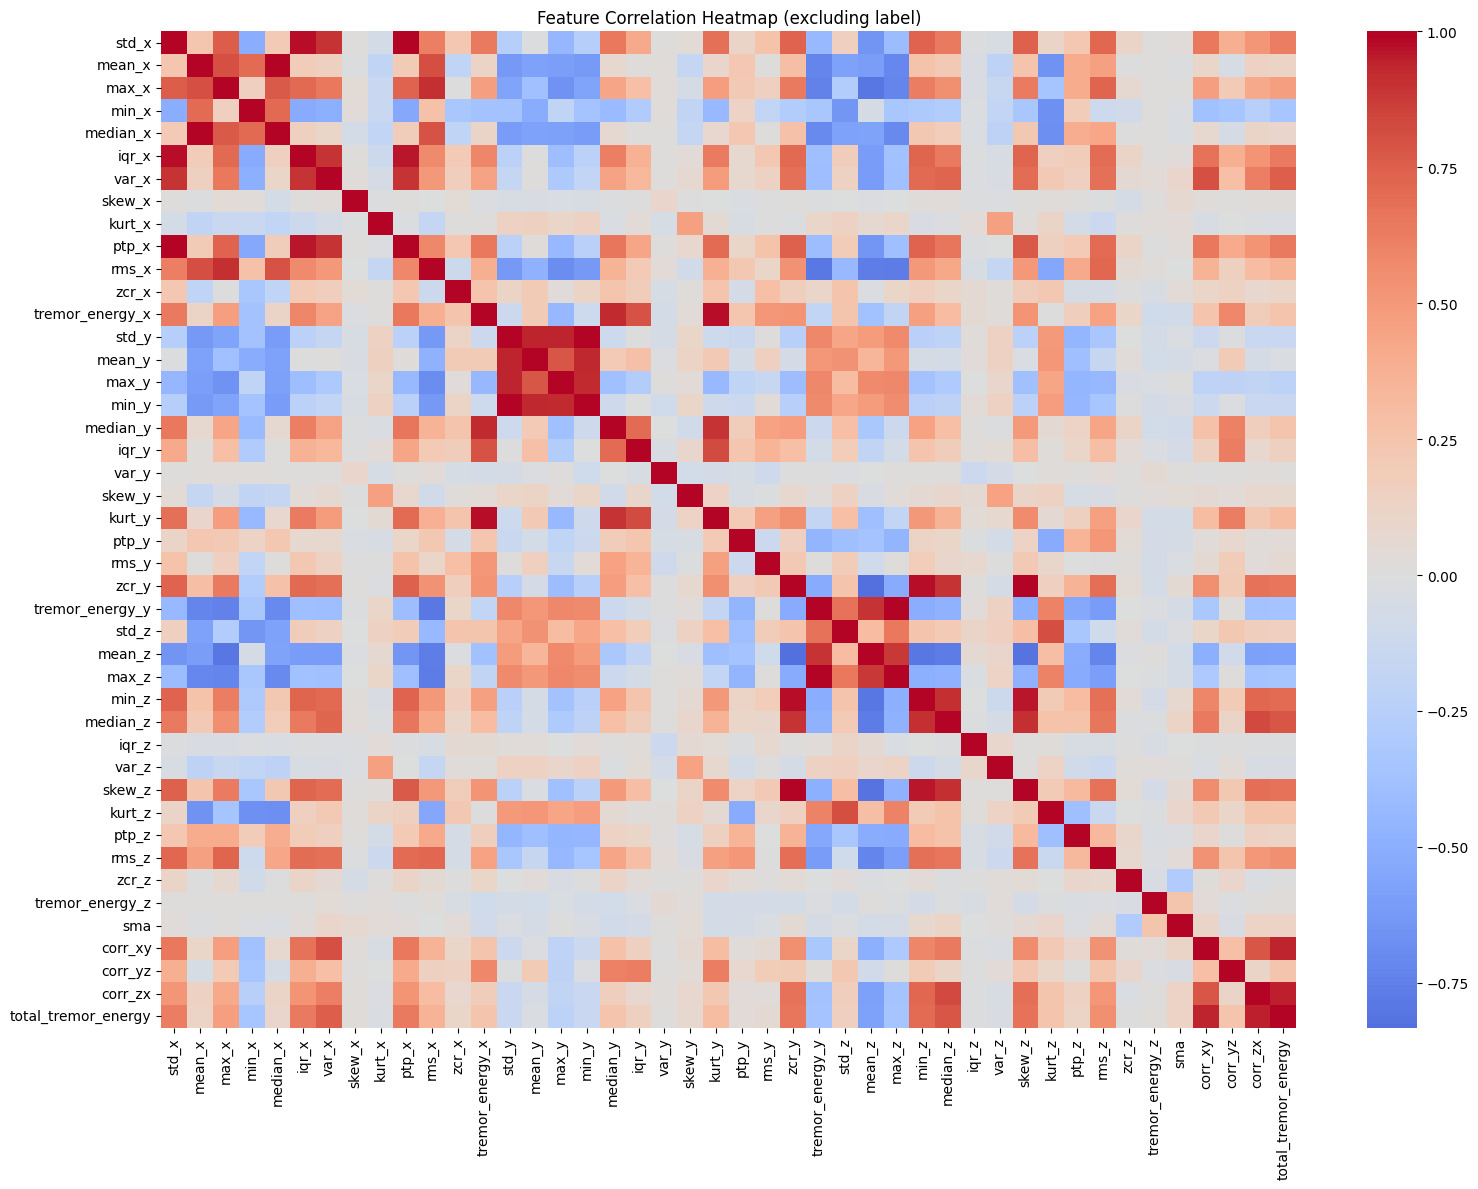

In [127]:
all_df = pd.read_csv('../data/all_feats_and_labels_wsize_0.5_overlap_0.15.csv')
all_df = all_df.dropna()  # Drop rows with NaN values
print(all_df.shape)
# all_features_and_labels_df.columns
plot_corr(all_df)

# Split the data

In [96]:
def split_by_position(X, y, start_ratio=0.0, train_ratio=0.7):
    """
    Split dataset into train/test without shuffling.
    
    Parameters:
    - X, y: features and labels
    - start_ratio: float in [0, 1), where to start the 70% slice
    - train_ratio: proportion of the data to use as training (e.g. 0.7)

    Returns:
    - X_train, X_test, y_train, y_test
    """
    assert 0 <= start_ratio < 1, "start_ratio must be in [0, 1)"
    assert 0 < train_ratio <= 1, "train_ratio must be in (0, 1]"

    total_len = len(X)
    start_index = int(start_ratio * total_len)
    end_index = start_index + int(train_ratio * total_len)

    # Handle edge case where end_index exceeds total_len
    if end_index > total_len:
        end_index = total_len

    X_train = X[start_index:end_index]
    y_train = y[start_index:end_index]

    # Use everything else for test
    X_test = np.concatenate((X[:start_index], X[end_index:]), axis=0)
    y_test = np.concatenate((y[:start_index], y[end_index:]), axis=0)

    return X_train, X_test, y_train, y_test

In [128]:
X = all_df.drop(columns=['label', 'subject']).values
y = all_df['label'].values

In [ ]:
# don't use this split, it gives bad performance
# X_train, X_test, y_train, y_test = split_by_position(X, y, start_ratio=0.05, train_ratio=0.7)
# print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
# print(f'y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}')
# print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

X_train_shape: (22230, 44), X_test_shape: (9528, 44)
y_train_shape: (22230,), y_test_shape: (9528,)
y_train_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}
 y_test_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}


In [129]:
# split data into 70% training and 30% testing, while preserving the class distribution in the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)
print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
print(f'y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}')
print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

X_train_shape: (31972, 44), X_test_shape: (13703, 44)
y_train_shape: (31972,), y_test_shape: (13703,)
y_train_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}
 y_test_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}


# Handle imbalanced classes

## ADASYN

In [ ]:
# from imblearn.over_sampling import ADASYN

# ada = ADASYN(random_state=42)

# X_resampled, y_resampled = ada.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')
#### NOTE: ADASYN does not work well with this dataset. ###

## SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (31758, 40), y: (31758,)
X_resampled: (34080, 40), y_resampled: (34080,)


## Random Over Sampler

In [133]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X_train, y_train)

print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (31972, 44), y: (31972,)
X_resampled: (48970, 44), y_resampled: (48970,)


## Plot the distribution of the original and resampled data

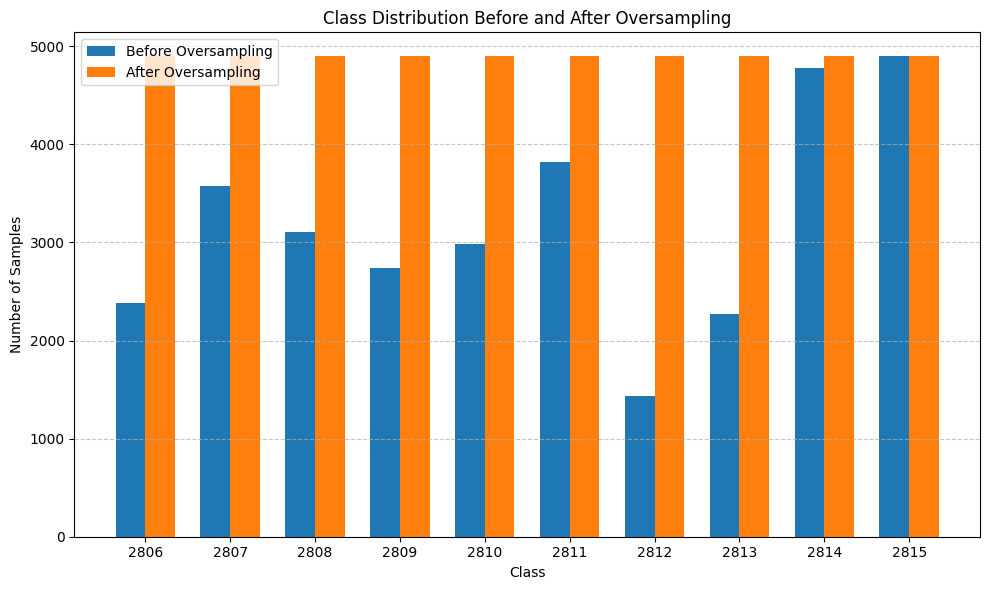

In [134]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences
counter_before = Counter(y_train)
counter_after = Counter(y_resampled)

# Get sorted class labels
classes = sorted(list(set(y_train)))
counts_before = [counter_before[cls] for cls in classes]
counts_after = [counter_after[cls] for cls in classes]

# Plotting
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, counts_before, width=width, label='Before Oversampling')
plt.bar(x + width/2, counts_after, width=width, label='After Oversampling')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before and After Oversampling')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Only Machine Learning, No Deep Learning

In [112]:
# for ploting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_predict):
    # compute confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_predict)
    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## LabelSpreading

              precision    recall  f1-score   support

        2806       0.31      0.37      0.34      1019
        2807       0.40      0.34      0.37      1534
        2808       0.28      0.28      0.28      1330
        2809       0.23      0.29      0.26      1175
        2810       0.33      0.35      0.34      1278
        2811       0.39      0.32      0.35      1636
        2812       0.11      0.26      0.16       614
        2813       0.26      0.34      0.29       971
        2814       0.56      0.42      0.48      2047
        2815       0.69      0.47      0.56      2099

    accuracy                           0.36     13703
   macro avg       0.36      0.34      0.34     13703
weighted avg       0.41      0.36      0.38     13703



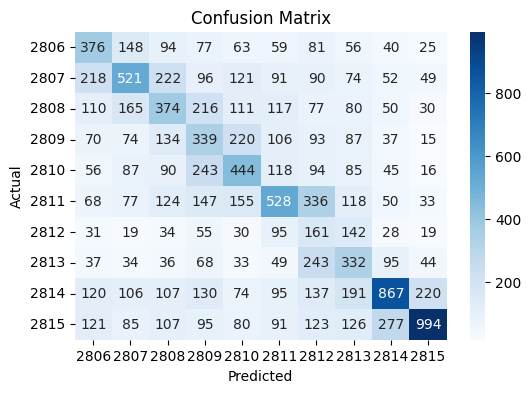

In [135]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report

# kernel_list = ['rbf', 'knn']
# max_iter_list = [50, 100, 200, 300, 1000]
# for ker in kernel_list:
#     for it in max_iter_list:
        # lspred = LabelSpreading(kernel=ker, alpha=0.5, max_iter=it)
        # lspred.fit(X_train, y_train)
        # # predict
        # y_predict = lspred.predict(X_test)
        # print(classification_report(y_test, y_predict))

lspred = LabelSpreading(kernel='knn', alpha=0.5, max_iter=50)
lspred.fit(X_resampled, y_resampled)
y_predict = lspred.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)

## RandomForest

              precision    recall  f1-score   support

        2806       0.43      0.42      0.43      1019
        2807       0.47      0.44      0.45      1534
        2808       0.40      0.38      0.39      1330
        2809       0.27      0.30      0.28      1175
        2810       0.45      0.43      0.44      1278
        2811       0.49      0.50      0.50      1636
        2812       0.08      0.08      0.08       614
        2813       0.42      0.41      0.42       971
        2814       0.64      0.69      0.67      2047
        2815       0.71      0.68      0.70      2099

    accuracy                           0.48     13703
   macro avg       0.44      0.43      0.44     13703
weighted avg       0.49      0.48      0.48     13703



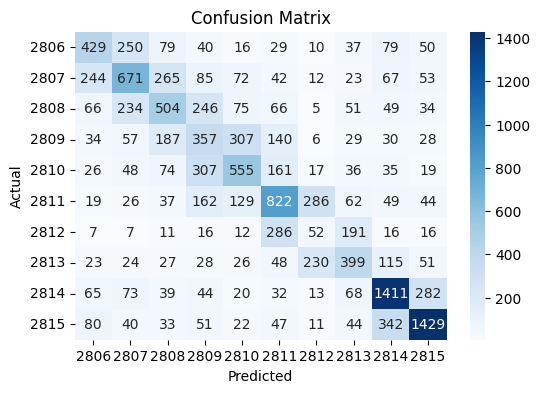

In [136]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)
### NOTE: without over sampling random forest performs better ###

## ExtraTreesClassifier

              precision    recall  f1-score   support

        2806       0.46      0.54      0.50      1019
        2807       0.53      0.57      0.55      1534
        2808       0.50      0.42      0.46      1330
        2809       0.41      0.42      0.41      1175
        2810       0.55      0.45      0.50      1278
        2811       0.55      0.52      0.53      1636
        2812       0.36      0.21      0.27       614
        2813       0.55      0.44      0.49       971
        2814       0.57      0.70      0.63      2047
        2815       0.64      0.71      0.67      2099

    accuracy                           0.54     13703
   macro avg       0.51      0.50      0.50     13703
weighted avg       0.53      0.54      0.53     13703



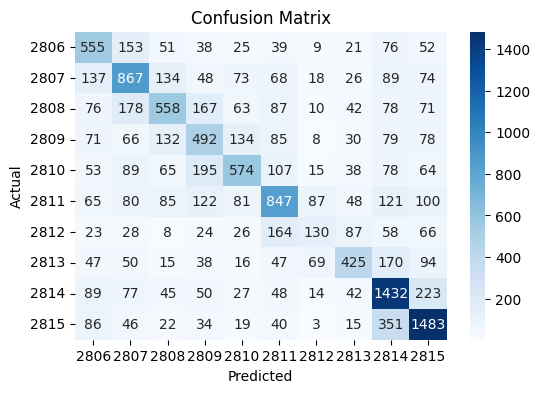

In [132]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
etc.fit(X_resampled, y_resampled)
y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)
# ExtraTrees and RandomForest perform similarly

# Conclusion

In conclusion, the model performance does not change much: 
- While increasing the amount of features -> chosen features not effective.
- While decreasing the window size. However, there is STILL a slightly increase in performance .
On the other hand, the model performance change:
- While over sampling not applied, the model performance increased, and vice versa.

In comparison with other machine learning methods:
- Extra Trees and Random Forest have similarity in performance.
- While Label Spreading is not as good as the above algorithms.